# Parcourir les rues de Paris

In [ ]:
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


Cette idée vient d'une soirée Google Code initiée par Google et à laquelle des élèves de l'ENSAE ont participé. On dispose de la description des rues de Paris (qu'on considèrera comme des lignes droites). On veut déterminer le trajet de huit voitures de telle sorte qu'elles parcourent la ville le plus rapidement possible. On supposera deux cas :

- Les voitures peuvent être placées n'importe où dans la ville.
- Les voitures démarrent et reviennent au même point de départ, le même pour toutes.

Ce notebook décrit comment récupérer les données et propose une solution.

In [ ]:
from pyquickhelper.ipythonhelper import add_notebook_menu
add_notebook_menu()

## Les données

On récupère les données sur Internet.

In [ ]:
import pyensae
data = pyensae.download_data("paris_54000.zip")
data

    downloading of  http://www.xavierdupre.fr/enseignement/complements/paris_54000.zip  to  paris_54000.zip
    unzipped  paris_54000.txt  to  .\paris_54000.txt


['.\\paris_54000.txt']

On extrait du fichier l'ensemble des carrefours (vertices) et des rues ou segment de rues (edges).

In [ ]:
name = data[0]
with open(name, "r") as f : lines = f.readlines()
    
vertices = []
edges    = [ ]
for i,line in enumerate(lines) :
    spl = line.strip("\n\r").split(" ")
    if len(spl) == 2 :
        vertices.append ( (float(spl[0]), float(spl[1]) ) )
    elif len(spl) == 5 and i > 0:
        v1,v2 = int(spl[0]),int(spl[1])
        ways = int(spl[2]) # dans les deux sens ou pas
        p1 = vertices[v1]
        p2 = vertices[v2]
        edges.append ( (v1,v2,ways,p1,p2) )
    elif i > 0 :
        raise Exception("unable to interpret line {0}: ".format(i) + line)
print("#E=",len(edges), "#V=",len(vertices), ">",max (max( _[0] for _ in edges),  max( _[1] for _ in edges)))

#E= 17958 #V= 11348 > 11347


On trace sur un graphique un échantillon des carrefours. On suppose la ville de Paris suffisamment petite et loin des pôles pour considérer les coordonnées comme cartésiennes (et non comme longitude/latitude).

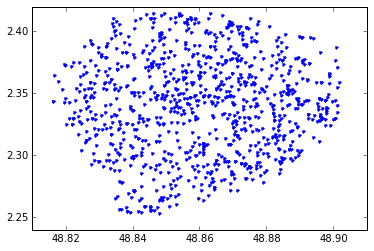

In [ ]:
import matplotlib.pyplot as plt
import random
sample = [ vertices[random.randint(0,len(vertices)-1)] for i in range(0,1000)]
plt.plot( [_[0] for _ in sample], [_[1] for _ in sample], ".")

Puis on dessine également un échantillon des rues.

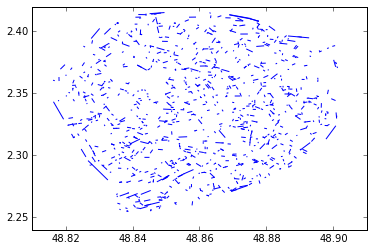

In [ ]:
sample = [ edges[random.randint(0,len(edges)-1)] for i in range(0,1000)]
for edge in sample:
    plt.plot( [_[0] for _ in edge[-2:]], [_[1] for _ in edge[-2:]], "b-")

Petite remarque : il n'y a pas de rues reliant le même carrefour :

In [ ]:
len ( list(e for e in edges if e[0]==e[1] ))

0

## Une première solution au premier problème

Ce problème est très similaire à celui du [portier chinois](http://fr.wikipedia.org/wiki/Probl%C3%A8me_du_postier_chinois). La solution qui suit n'est pas nécessaire la meilleure mais elle donne une idée de ce que peut-être une recherche un peu expérimentale sur le sujet.

Chaque noeud représente un carrefour et chaque rue est un arc reliant des deux carrefours. L'objectif est de parcourir tous les arcs du graphe avec 8 voitures. 

Premiere remarque, l'énoncé ne dit pas qu'il faut parcourir toutes les rues une seule fois. On conçoit aisément que ce serait l'idéal mais on ne sait pas si ce serait possible. Néanmoins, si une telle solution (un chemin passant une et une seule fois par toutes les rues) existe, elle est forcément optimale.

Deuxième remarque, les sens interdits rendent le problème plus complexe. On va dans un premier temps ne pas en tenir compte. On verra comment ajouter la contrainte par la suite et il y a aussi le problème des impasses. On peut néanmoins les contourner en les supprimant du graphe : il faut nécessairement faire demi-tour et il n'y a pas de meilleure solution.

Ces deux remarques étant faite, ce problème rappelle un peu le problème des sept ponts de [Konigsberg](http://fr.wikipedia.org/wiki/Probl%C3%A8me_des_sept_ponts_de_K%C3%B6nigsberg) : comment traverser passer par les sept de la ville une et une seule fois. Le mathématicien [Euler](http://fr.wikipedia.org/wiki/Leonhard_Euler) a répondu à cette question : c'est simple, il suffit que chaque noeud du graphe soit rejoint par un nombre pair de d'arc (= ponts) sauf au plus 2 (les noeuds de départ et d'arrivée). De cette façon, à chaque qu'on rejoint un noeud, il y a toujours une façon de repartir.

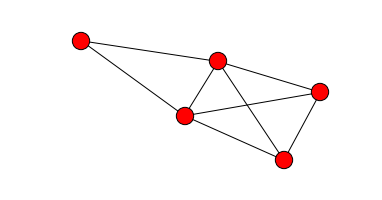

In [ ]:
import networkx as nx
g = nx.Graph()
for i,j in [(1,2),(1,3),(1,4),(2,3),(3,4),(4,5),(5,2),(2,4) ]:
    g.add_edge( i,j )
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(6,3))
nx.draw(g, ax = ax)

On ne peut pas trouver une chemin qui parcourt tous les arcs du graphe précédent une et une seule fois. Qu'en est-il du graphe de la ville de Paris ? On compte les noeuds qui ont un nombre pairs et impairs d'arcs les rejoignant (on appelle cela le [degré](http://fr.wikipedia.org/wiki/Degr%C3%A9_(th%C3%A9orie_des_graphes))).

In [ ]:
nb_edge = { }
for edge in edges :
    v1,v2 = edge[:2]
    nb_edge[v1] = nb_edge.get(v1,0)+1
    nb_edge[v2] = nb_edge.get(v2,0)+1
parite = { }
for k,v in nb_edge.items():
    parite[v] = parite.get(v,0) + 1
[ sorted(parite.items()) ]

[[(2, 1337), (3, 7103), (4, 2657), (5, 209), (6, 35), (7, 6), (8, 1)]]

On remarque que la plupart des carrefours sont le départ de 3 rues. Qu'à cela ne tienne, pourquoi ne pas ajouter des arcs entre des noeuds de degré impair jusqu'à ce qu'il n'y en ait plus que 2. De cette façon, il sera facile de construire un seul chemin parcourant toutes les rues. Comment ajouter ces arcs ? Cela va se faire en deux étapes :

- On utilise l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford) pour construire une matrice des plus courts chemins entre tous les noeuds.
- On s'inspire de l'algorithme de poids minimal [Kruskal](http://fr.wikipedia.org/wiki/Algorithme_de_Kruskal). On trie les arcs par ordre croissant de distance. On ajoute ceux qui réduisent le nombre de noeuds de degré impairs en les prenant dans cet ordre.

**Quelques justifications :** le meilleur parcours ne pourra pas descendre en deça de la somme des distances des rues puisqu'il faut toutes les parcourir. De plus, s'il existe un chemin qui parcourt toutes les rues, en dédoublant toutes celles parcourues plus d'une fois, il est facile de rendre ce chemin *eulérien* dans un graphe légèrement modifié par rapport au graphe initial.

### Etape 1 : la matrice Bellman

Je ne détaillerai pas trop, la page Wikipedia est assez claire. Dans un premier temps on calcule la longueur de chaque arc (de façon cartésienne). Une autre distance ([Haversine](http://en.wikipedia.org/wiki/Haversine_formula)) ne changerait pas le raisonnement.

In [ ]:
def distance(p1,p2):
    return ((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)**0.5
edges = [ edge + (distance( edge[-2],edge[-1]),) for edge in edges]

Ensuite, on implémente l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford).

In [ ]:
import datetime
init = { (e[0],e[1]) : e[-1] for e in edges }
init.update ( { (e[1],e[0]) : e[-1] for e in edges } )

edges_from = {  }
for e in edges :
    if e[0] not in edges_from : edges_from[e[0]] = []
    if e[1] not in edges_from : edges_from[e[1]] = []
    edges_from[e[0]].append(e)
    edges_from[e[1]].append( (e[1], e[0], e[2], e[4], e[3], e[5] ) )
    
modif = 1
total_possible_edges = len(edges_from)**2
it = 0
while modif > 0 :
    modif = 0
    initc = init.copy()   # to avoid RuntimeError: dictionary changed size during iteration
    s = 0
    for i,d in initc.items() :
        fromi2 = edges_from[i[1]]
        s += d
        for e in fromi2 :
            if i[0] == e[1] : # on fait attention à ne pas ajouter de boucle sur le même noeud
                continue
            new_e = i[0], e[1]
            new_d = d + e[-1]
            if new_e not in init or init[new_e] > new_d :
                init[new_e] = new_d 
                modif += 1
    print(datetime.datetime.now(), "iteration ", it, " modif ", modif, " # ", len(initc),"/",total_possible_edges,"=", 
            "%1.2f" %(len(initc)*100 / total_possible_edges) + "%")
    it += 1
    if it > 6 : break

2015-04-12 01:16:40.590690 iteration  0  modif  72870  #  35916 / 128777104 = 0.03%
2015-04-12 01:16:41.340550 iteration  1  modif  120368  #  104842 / 128777104 = 0.08%
2015-04-12 01:16:42.887810 iteration  2  modif  180646  #  213826 / 128777104 = 0.17%
2015-04-12 01:16:45.510596 iteration  3  modif  255702  #  368960 / 128777104 = 0.29%
2015-04-12 01:16:49.759326 iteration  4  modif  347092  #  576106 / 128777104 = 0.45%
2015-04-12 01:16:55.781000 iteration  5  modif  455899  #  839276 / 128777104 = 0.65%
2015-04-12 01:17:04.276258 iteration  6  modif  584263  #  1162870 / 128777104 = 0.90%


On s'aperçoit vite que cela va être très très long. On décide alors de ne considérer que les paires de noeuds pour lesquelles la distance à vol d'oiseau est inférieure au plus grand segment de rue ou inférieure à cette distance multipliée par un coefficient.

In [ ]:
max_segment = max( e[-1] for e in edges )
max_segment

0.017418989861067814

On calcule les arcs admissibles (en espérant que les noeuds de degré impairs seront bien dedans). Cette étape prend quelques minutes :

In [ ]:
possibles = { (e[0],e[1]) : e[-1] for e in edges }
possibles.update ( { (e[1],e[0]) : e[-1] for e in edges } )
initial = possibles.copy()
for i1,v1 in enumerate(vertices) :
    for i2 in range(i1+1,len(vertices)):
        v2 = vertices[i2]
        d = distance(v1,v2)
        if d < max_segment / 2 :         # on ajuste le seuil
            possibles [ i1,i2 ] = d
            possibles [ i2,i1 ] = d
print("original",len(initial),"/",total_possible_edges,"=", len(initial)/total_possible_edges)
print("addition",len(possibles)-len(initial),"/",total_possible_edges,"=", (len(possibles)-len(initial))/total_possible_edges)

original 35916 / 128777104 = 0.000278900510140374
addition 2875586 / 128777104 = 0.022329947721141486


On vérifie que les noeuds de degré impairs font tous partie de l'ensemble des noeuds recevant de nouveaux arcs. La matrice de Bellman envisagera au pire 2.2% de toutes les distances possibles.

In [ ]:
allv = { p[0]:True for p in possibles if p not in initial } # possibles est symétrique
for v,p in nb_edge.items() :
    if p % 2 == 1 and v not in allv :
        raise Exception("problème pour le noeud: {0}".format(v))
print("si vous voyez cette ligne, c'est que tout est bon")

si vous voyez cette ligne, c'est que tout est bon


On continue avec l'algorithme de [Bellman-Ford](http://fr.wikipedia.org/wiki/Algorithme_de_Bellman-Ford) modifié :

In [ ]:
import datetime
init = { (e[0],e[1]) : e[-1] for e in edges }
init.update ( { (e[1],e[0]) : e[-1] for e in edges } )

edges_from = {  }
for e in edges :
    if e[0] not in edges_from : edges_from[e[0]] = []
    if e[1] not in edges_from : edges_from[e[1]] = []
    edges_from[e[0]].append(e)
    edges_from[e[1]].append( (e[1], e[0], e[2], e[4], e[3], e[5] ) )
    
modif = 1
total_possible_edges = len(edges_from)**2
it = 0
while modif > 0 :
    modif = 0
    initc = init.copy()   # to avoid RuntimeError: dictionary changed size during iteration
    s = 0
    for i,d in initc.items() :
        if i not in possibles : 
            continue  # we skip undesired edges ------------------- addition
        fromi2 = edges_from[i[1]]
        s += d
        for e in fromi2 :
            if i[0] == e[1] : # on fait attention à ne pas ajouter de boucle sur le même noeud
                continue
            new_e = i[0], e[1]
            new_d = d + e[-1]
            if new_e not in init or init[new_e] > new_d :
                init[new_e] = new_d 
                modif += 1
    print(datetime.datetime.now(), "iteration ", it, " modif ", modif, " # ", len(initc),"/",total_possible_edges,"=", 
            "%1.2f" %(len(initc)*100 / total_possible_edges) + "%")
    it += 1
    if it > 20 : 
        break

2015-04-12 01:18:45.389333 iteration  0  modif  72870  #  35916 / 128777104 = 0.03%
2015-04-12 01:18:46.179293 iteration  1  modif  119604  #  104842 / 128777104 = 0.08%
2015-04-12 01:18:47.853483 iteration  2  modif  178033  #  213086 / 128777104 = 0.17%
2015-04-12 01:18:50.790772 iteration  3  modif  248648  #  365751 / 128777104 = 0.28%
2015-04-12 01:18:55.302585 iteration  4  modif  330443  #  566457 / 128777104 = 0.44%
2015-04-12 01:19:02.002318 iteration  5  modif  419549  #  815211 / 128777104 = 0.63%
2015-04-12 01:19:11.623367 iteration  6  modif  508807  #  1109019 / 128777104 = 0.86%
2015-04-12 01:19:23.579840 iteration  7  modif  585973  #  1438040 / 128777104 = 1.12%
2015-04-12 01:19:38.370350 iteration  8  modif  639491  #  1785232 / 128777104 = 1.39%
2015-04-12 01:19:56.035255 iteration  9  modif  656961  #  2127675 / 128777104 = 1.65%
2015-04-12 01:20:16.436453 iteration  10  modif  638987  #  2441604 / 128777104 = 1.90%
2015-04-12 01:20:39.075644 iteration  11  modif  5

L'algorithme consiste à regarder les chemins $a \rightarrow b \rightarrow c$ et à comparer s'il est plus rapide que $a \rightarrow c$. 2.6% > 2.2% parce que le filtre est appliqué seulement sur $a \rightarrow b$. Finalement, on considère les arcs ajoutés puis on retire les arcs originaux.

In [ ]:
original = { (e[0],e[1]) : e[-1] for e in edges }
original.update ( { (e[1],e[0]) : e[-1] for e in edges } )
additions = { k:v for k,v in init.items() if k not in original }
additions.update( { (k[1],k[0]):v for k,v in additions.items() } )    

### Kruskall

On trie les arcs par distance croissante, on enlève les arcs qui ne relient pas des noeuds de degré impair puis on les ajoute un par jusqu'à ce qu'il n'y ait plus d'arc de degré impair.

In [ ]:
degre = { }
for k,v in original.items() :  # original est symétrique
    degre[k[0]] = degre.get(k[0],0) + 1

tri = [ (v,k) for k,v in additions.items() if degre[k[0]] %2 == 1 and degre[k[1]] %2 == 1  ]
tri.extend( [ (v,k) for k,v in original.items() if degre[k[0]] %2 == 1 and degre[k[1]] %2 == 1  ] )
tri.sort()

impairs = sum ( v%2 for k,v in degre.items()  )

added_edges = [] 

for v,a in tri :
    if degre[a[0]] % 2 == 1 and degre[a[1]] % 2 == 1 :
        # il faut refaire le test car degre peut changer à chaque itération
        degre[a[0]] += 1
        degre[a[1]] += 1
        added_edges.append ( a + (v,) )
        impairs -= 2
        if impairs <= 0 :
            break

# on vérifie
print("nb degré impairs",impairs, "nombre d'arcs ajoutés",len(added_edges))
print("longueur ajoutée ", sum( v for a,b,v in added_edges ))
print("longueur initiale ", sum( e[-1] for e in edges ))

nb degré impairs 22 nombre d'arcs ajoutés 3648
longueur ajoutée  3.5423464430662346
longueur initiale  17.418504406203844


Le nombre de noeuds impairs obtenus à la fin doit être inférieur à 2 pour être sûr de trouver un chemin (mais on choisira 0 pour avoir un circuit eulérien). Mon premier essai n'a pas donné satisfaction (92 noeuds impairs restant) car j'avais choisi un seuil (max_segment / 4) trop petit lors de la sélection des arcs à ajouter. J'ai augmenté le seuil par la suite mais il reste encore 22 noeuds de degré impairs. On a le choix entre augmenter ce seuil mais l'algorithme est déjà long ou chercher dans une autre direction comme laisser l'algorithme de Bellman explorer les noeuds de degré impairs. Ca ne veut pas forcément dire qu'il manque des arcs mais que peut-être ils sont mal choisis. Si l'arc $i \rightarrow j$ est choisi, l'arc $j \rightarrow k$ ne le sera pas car $j$ aura un degré pair. Mais dans ce cas, si l'arc $j \rightarrow k$ était le dernier arc disponible pour combler $k$, on est coincé. On peut augmenter le seuil encore mais cela risquee de prendre du temps et puis cela ne fonctionnerait pas toujours sur tous les jeux de données.

On pourait alors écrire une sorte d'algorithme itératif qui exécute l'algorithme de Bellman, puis lance celui qui ajoute les arcs. Puis on revient au premier en ajoutant plus d'arcs autour des noeuds problèmatique lors de la seconde étape. L'ensemble est un peu long pour tenir dans un notebook mais le code est celui de la fonction [eulerien_extension](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/ensae_teaching_cs/special/rues_paris.html#special.rues_paris.eulerien_extension). Je conseille également la lecture de cet article : [Efficient Algorithms for Eulerian Extension](http://www.akt.tu-berlin.de/fileadmin/fg34/publications-akt/euler_short.pdf) (voir également [On Making Directed Graphs Eulerian](http://arxiv.org/abs/1101.4283)). L'exécution qui suit prend une vingtaine de minutes.

In [ ]:
from ensae_teaching_cs.special.rues_paris import eulerien_extension, distance_paris,get_data
print("data")
edges = get_data()
print("start, nb edges", len(edges))
added = eulerien_extension(edges, distance=distance_paris)
print("end, nb added", len(added))

data
start, nb edges 17958
possible_edges
original 17958 / 64382878.0 = 0.00027892508936925745
addition 1312214 / 64382878.0 = 0.020381412586122666
next
iteration  0  modif  72876  #  17958 / 64382878 = 0.03%
iteration  1  modif  119544  #  52421 / 64382878 = 0.08%
iteration  2  modif  177609  #  106511 / 64382878 = 0.17%
iteration  3  modif  247689  #  182680 / 64382878 = 0.28%
iteration  4  modif  327843  #  282626 / 64382878 = 0.44%
iteration  5  modif  413418  #  405980 / 64382878 = 0.63%
iteration  6  modif  496069  #  550546 / 64382878 = 0.86%
iteration  7  modif  561366  #  710517 / 64382878 = 1.10%
iteration  8  modif  598700  #  875788 / 64382878 = 1.36%
iteration  9  modif  600000  #  1034325 / 64382878 = 1.61%
iteration  10  modif  567801  #  1175548 / 64382878 = 1.83%
iteration  11  modif  510076  #  1292961 / 64382878 = 2.01%
iteration  12  modif  433796  #  1384196 / 64382878 = 2.15%
iteration  13  modif  349510  #  1449682 / 64382878 = 2.25%
iteration  14  modif  267371 

On enregistre le résultat où on souhaite recommencer à partir de ce moment-là plus tard.

In [ ]:
with open("added.txt","w") as f : f.write(str(added))

Et si vous voulez le retrouver :

In [ ]:
from ensae_teaching_cs.data import added
data = added()

In [ ]:
from ensae_teaching_cs.special.rues_paris import eulerien_extension, distance_paris, get_data
edges = get_data()

with open(data, "r") as f: text = f.read()
added_edges = eval(text)

### Chemin Eulérien

A cet instant, on n'a pas vraiment besoin de connaître la longueur du chemin eulérien passant par tous les arcs. Il s'agit de la somme des arcs initiaux et ajoutés (soit environ 334 + 1511). On suppose qu'il n'y qu'une composante connexe. Construire le chemin eulérien fait apparaître quelques difficultés comme la suivante : on parcourt le graphe dans un sens mais on peut laisser de côté une partie du chemin et créer une seconde composante connexe.

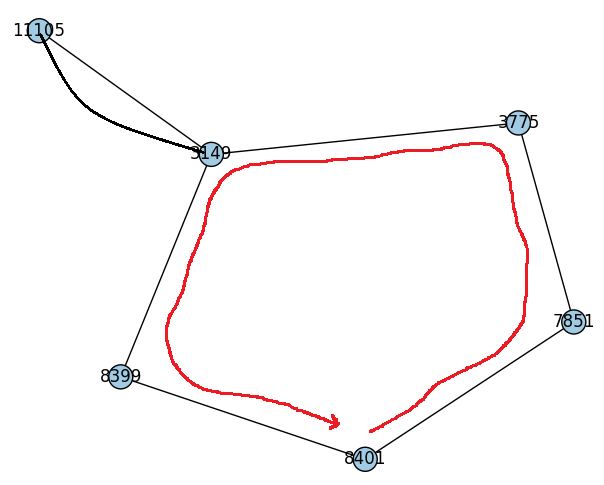

In [ ]:
from pyquickhelper.helpgen import NbImage
NbImage("euler.png")

Quelques algorithmes sont disponibles sur cette page [Eulerian_path](http://en.wikipedia.org/wiki/Eulerian_path). L'algorithme de Hierholzer consiste à commencer un chemin eulérien qui peut revenir au premier avant d'avoir tout parcouru. Dans ce cas, on parcourt les noeuds du graphe pour trouver un noeud qui repart ailleurs et qui revient au même noeud. On insert cette boucle dans le chemin initial. Tout d'abord, on construit une structure qui pour chaque noeud associe les noeuds suivant. La fonction [euler_path](http://www.xavierdupre.fr/app/ensae_teaching_cs/helpsphinx3/ensae_teaching_cs/special/rues_paris.html#special.rues_paris.eurler_path)

In [ ]:
from ensae_teaching_cs.special.rues_paris import euler_path
path = euler_path(edges, added_edges)
path[:5]

[(2121, ['street', 3, 2121, 0.049532522902426074]),
 (10363, ['street', 2121, 10363, 0.1474817976215633]),
 (3517, ['street', 3517, 10363, 0.10602477572757586]),
 (2829, ['street', 2829, 3517, 0.03409802890007801]),
 (3515, ['street', 3515, 2829, 0.060836636019222866])]

Le label ``street`` signifie que l'arête provient de l'ensemble des rues, le label ``jump`` signifie que c'est une arête ajoutée. Pour couper le parcours en 8 (8 voitures), il suffit de couper le chemin en 8 parts presque égales en trouvant 8 arêtes ``jump`` presque également réparties le long du chemin eulérien. On peut bien évidemment couper à une arête ``street`` mais celle-là devra faire partie d'un des deux ensembles pas l'arête ``jump`` qui peut être jetée. On peut envisager une approche dichotomique. Couper en deux, recouper en deux chaque intervalle et minimiser sur la meilleur arête ``jump`` du début.

Il reste maintenant à prendre en compte les sens interdits. Cette modification peut intervenir à deux endroits :

* Soit le nombre de sens interdit est faible et on peut s'en dépatouiller en parcourant le plus possible des rues dans le bon sens, en choisissant le plus les arcs dans le bon sens lors de la création du chemin eulérien.
* Soit on crée un graphe eulérien orienté (pour chaque noeud, les nombres d'arêtes sortantes et entrantes sont égaux, voir [Euler Circuit in a Directed Graph](http://www.geeksforgeeks.org/euler-circuit-directed-graph/)).

Dans le cas où on souhaite que les voitures partent toutes du même point et reviennent à ce même point, la solution précédente fournira une borne supérieure (il suffit d'ajouter des arêtes ``jump`` pour amener et ramener les voitures).